Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [2]:
NAME = "Yibo Liu"
COLLABORATORS = ""

---

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Assignment 6

In [1]:
# Run this before any other code cell
# This downloads the csv data files into the same directory where you have saved this notebook

import urllib.request
from pathlib import Path
import os
path = Path()

import warnings
warnings.filterwarnings("ignore")

# Dictionary of file names and download links
files = {'AEP_hourly.csv':'https://storage.googleapis.com/aipi_datasets/AEP_hourly.csv',
        'Retail_Sales.csv': 'https://storage.googleapis.com/aipi_datasets/Retail_Sales.csv'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error

# Disable pandas warnings
pd.options.mode.chained_assignment = None  # default='warn'

## Part 1: Energy consumption
Run the below cell to read in the data for Part 1 (may take up to a minute to convert the dates to pandas datetime).  The data contains an hourly datetime timestamp which we will use as the index, and a corresponding hourly energy consumption value in MW.

In [3]:
aep_data = pd.read_csv('AEP_hourly.csv',usecols=['Datetime','AEP_MW'],parse_dates=['Datetime'],index_col='Datetime')
aep_data.head()

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379
2004-10-01 02:00:00,11935
2004-10-01 03:00:00,11692
2004-10-01 04:00:00,11597
2004-10-01 05:00:00,11681


We will use a subset of the data for our analysis: the data from January 1 2005 00:00 to December 31 2009 23:00.  Running the cell below will create this subset.

In [4]:
# Take a subset for analysis
aep_data_subset = aep_data.loc[(aep_data.index>=pd.to_datetime('2005-01-01 00:00')) & (aep_data.index<=pd.to_datetime('2009-12-31 23:00'))]
aep_data_subset.head()

,AEP_MW
Datetime,
2005-01-01 00:00:00,12892
2005-01-01 01:00:00,12316
2005-01-01 02:00:00,11890
2005-01-01 03:00:00,11579
2005-01-01 04:00:00,11461


### Question 1.1 [5 points]
Complete the below function `identify_periods()`.  The function should return 3 boolean (True/False) values in the following order:  
-`annual_period`: Set to `True` if the data appears to have a visible annual period (values vary based on day of year), otherwise `False`  
-`weekly_period`: Set to `True` if the data appears to have a visible weekly period (values vary based on day of week), otherwise `False`  
-`daily_period`: Set to `True` if the data appears to have a visible daily period (values vary based on time of day), otherwise `False`

For example, if there is a visible annual period but not a weekly or daily period, you would set the values to return as follows:  
`annual_period=True`  
`weekly_period=False`  
`daily_period=False`  
`return annual_period, weekly_period, daily_period`

You can determine these periods through visualization of the data.  Note we are not asking you in this question to confirm if any noticed differences are statistically significant, only whether you are able to notice a visible difference indicating a likely period based on various plots you create.

In [5]:
from pickle import TRUE
def plot_data(data):
    plt.figure(figsize=(30,10))
    plt.plot(data)
    plt.show()

def identify_periods(data):
    '''
    Uses visualizations to determine whether the data has an annual, weekly and/or daily period

    Inputs:
        data(DataFrame): dataframe containing the hourly energy consumption in MW
    
    Returns:
        annual_period(bool): boolean indicating whether the data has an observed annual seasonality
        weekly_period(bool): boolean indicating whether the data has an observed weekly seasonality
        daily_period(bool): boolean indicating whether the data has an observed daily seasonality
    '''
    # YOUR CODE HERE
    print(data.dtypes)
    plot_data(data)
    '''From the plots, we can tell that 2005 and 2009 basically have identical pattern, so the annual seasonality is true'''
    '''From the plots, we can tell that the two weeks basically have identical pattern, so the annual seasonality is true'''
    '''From the plots, we can tell that the two days basically have identical pattern, so the annual seasonality is true'''
    return True, True, True

AEP_MW    int64
dtype: object


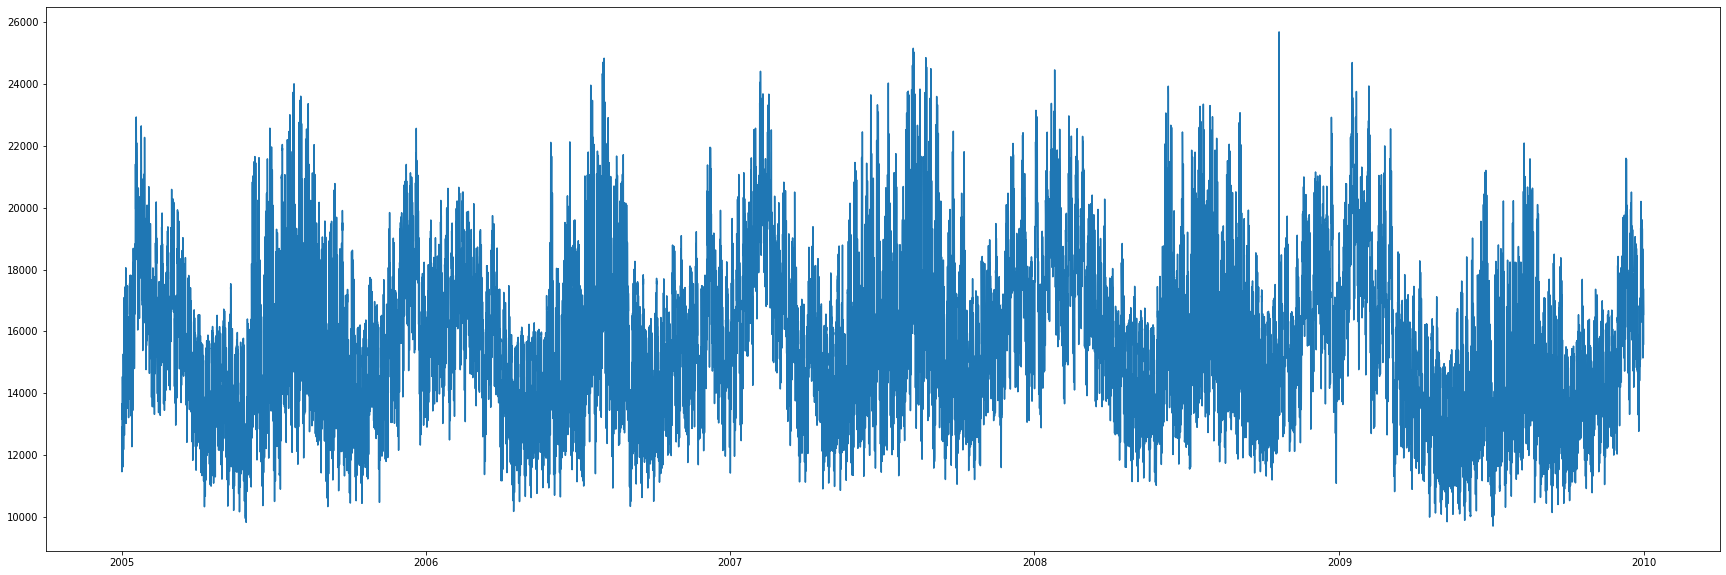

In [6]:
# Test cell for identify_periods()
annual_period,weekly_period,daily_period = identify_periods(aep_data_subset.copy())
for p in [annual_period,weekly_period,daily_period]:
    assert type(p)==bool

# Hidden test below

### Question 1.2 [5 points]
Let's now look more closely at the possibility of a daily period.  This means that the energy consumption for a given hour of the day is autocorrelated with the consumption at the same time period the previous day (t-24 hrs).  Complete the function `autocorr24()` below.  Your function should return the boolean value True (e.g. `return True`) if there is a statistically significant autocorrelation (at a 95% confidence interval) of energy consumption with the previous value at a lag of 24 (1 day / 24 hours).  If you observe no statistically significant autocorrelation with a lag of 24 hours, your function should return the boolean value False (e.g. `return False`).

Hint: you can determine this by using the autocorrelation plot from the statsmodel library.

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

def autocorr24(data):
    '''
    Uses visualizations to determine whether the data has an annual, weekly and/or daily period

    Inputs:
        data(DataFrame): dataframe containing the hourly energy consumption in MW
    
    Returns:
        daily_period(bool): boolean indicating whether the data has an observed daily seasonality
    '''
    # YOUR CODE HERE
    plot_acf(data, lags=24)
    plt.xlabel('lag in hours')
    plt.show()
    return True

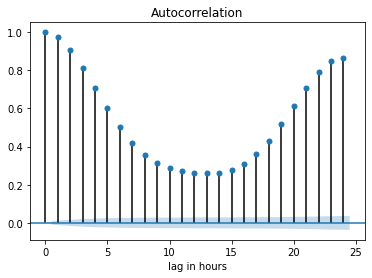

In [8]:
# Test cell for decompose_aep()
autocorr_bool = autocorr24(aep_data_subset.copy())
assert type(autocorr_bool) == bool

### Question 1.3 [15 points]
Understanding auto-correlation can be very useful in making short-term forecasts of the future. For example, assume an electric company needs to predict hourly consumption a day in advance.  The company could use known consumption for 12 noon to 1 pm to predict the 12 noon to 1 pm hour the next day, and so on. 

Complete the below function `aep_24hr_prediction()` which takes as input a subset of data in a dataframe and uses it to create a simple linear regression model which uses the consumption value at t - 24 hours as the single input feature to predict the consumption at time t.  Fit your model to the data beginning at 00:00 on January 2, 2005.  Then, generate predictions for each hour in the time interval of `aep_data_subset` beginning at 00:00 on January 2, 2005, and calculate the residuals (errors) of those predictions.  

Note: you will have a few rows in your data where there is no t-24 consumption value available (due to time changes for daylight savings time).  For simplicity just remove these rows in our data where there is no t-24 value prior to training your linear regression model, since it will not be able to train the model if your feature includes null values.

Your function should return the following in order:  
- The mean squared error (MSE) of your linear regression model using the single feature, as a float 
- The R-squared value of your model, as a float. 
- A pandas dataframe with the index being the datetime timestamp (day and hour), and containing only the following columns:  
    - 'AEP_MW': contains the energy consumption value from the current hour (the target we are trying to predict). 
    - 'PREDS': contains the predicted energy consumption value for the hour from your model. 
    - 'RESIDS': contains the residual of your prediction (the actual value minus the prediction)

In [21]:
import math
def aep_24hr_prediction(data):
    '''
    Trains a autoregression model using a lag of 24 hours to predict electricity demand

    Inputs:
        data(DataFrame): dataframe containing the hourly energy consumption in MW

    Returns:
        mse(float):In-sample Mean Squared Error of the autoregression model (calculated on training data)
        r2(float): In-sample R-squared value of the autoregression model (calculated on training data)
        results(DataFrame): DataFrame containing the actual values (AEP_MW), the predictions (PREDS) and the residuals (RESIDS) on the training data

    '''

    # YOUR CODE HERE
    data['PrevValue'] = data['AEP_MW'].shift(24, freq = 'H')
    df = data.iloc[24:]
    df = df.dropna(axis=0,how='any')

    model = LinearRegression()
    x = df['PrevValue'].values.reshape(-1,1)
    model.fit(X=x, y=df['AEP_MW'])

    preds = model.predict(x)
    result = pd.DataFrame()
    result['AEP_MW'] = df['AEP_MW']
    result['PREDS'] = preds
    result['RESIDS'] = result['AEP_MW'] - result['PREDS']
    # print(df.head())

    mse = np.sum(result['RESIDS']**2, axis=0)/result.shape[0]
    r2 = 1 - np.sum((result['RESIDS'])**2)/np.sum((df['AEP_MW']-np.mean(df['AEP_MW']))**2)

    return mse, r2, result

The simple linear model has R^2=0.750 and MSE=1680563.2


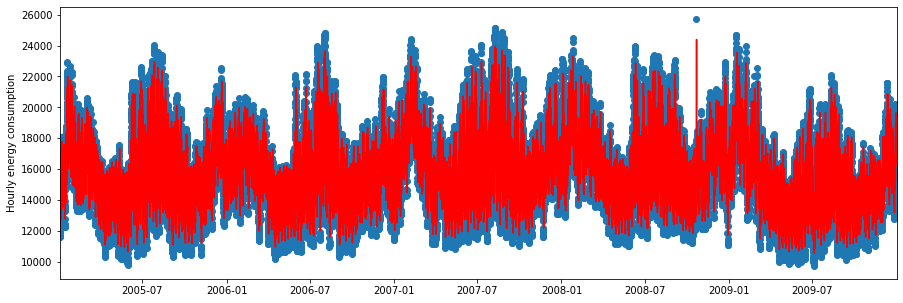

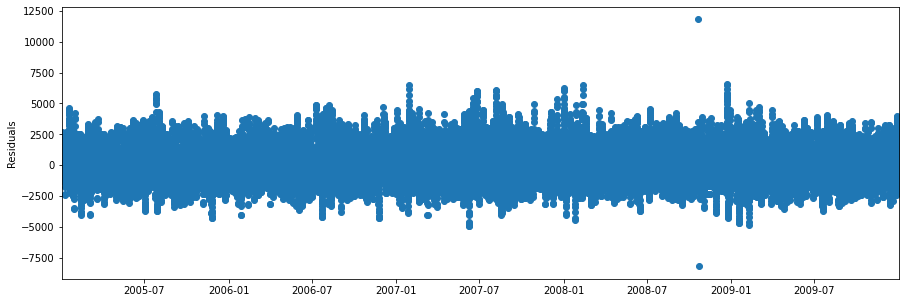

In [22]:
# Calculate and display the model performance statistics
mse,r2,data_out = aep_24hr_prediction(aep_data_subset.copy())
print('The simple linear model has R^2={:.3f} and MSE={:.1f}'.format(r2,mse))

# Plot the data and the predictions
plt.figure(figsize=(15,5))
plt.scatter(x=data_out.index, y=data_out['AEP_MW'])
plt.plot(data_out.index, data_out['PREDS'],color='red')
plt.xlim((data_out.index.min(),data_out.index.max()))
plt.ylabel('Hourly energy consumption')
plt.show()

plt.figure(figsize=(15,5))
plt.scatter(x=data_out.index, y=data_out['RESIDS'])
plt.xlim((data_out.index.min(),data_out.index.max()))
plt.ylabel('Residuals')
plt.show()

# Hidden tests below

## Part 2: Retail sales forecasting
In Part 2 we will be working with a set of retail sales data for each month in the time period.  Run the below cell to read in and display the data.

In [23]:
# Read in the data and display the head to see what data we have
retail_data = pd.read_csv("Retail_Sales.csv", parse_dates = ['DATE'],index_col='DATE')

# Take a subset of the data to use as training data for modeling
training_data = retail_data.loc[(retail_data.index.year >= 1992) & (retail_data.index.year <2003)]
training_data.head()

,Sales
DATE,
1992-01-01,1509.0
1992-02-01,1541.0
1992-03-01,1597.0
1992-04-01,1675.0
1992-05-01,1822.0


### Question 2.1 [5 points]
Complete the function `sales_period()` below.  The function should return the boolean True (e.g. `return True`) if the data displays an annual seasonality, and False if not.  To determine if the data likely has an annual seasonality you can plot the data and determine if you visually identify a recurring pattern each year.

In [24]:
def sales_period(data):
    '''
    Uses visualization to determine if the data displays an annual seasonality

    Inputs:
        data(DataFrame): dataframe with monthly sales data
    
    Returns:
        annual_period(bool): boolean indicating whether the data displays an annual period
    '''
    # YOUR CODE HERE
    plt.figure(figsize=(30,10))
    plt.plot(data)
    plt.show()
    return True

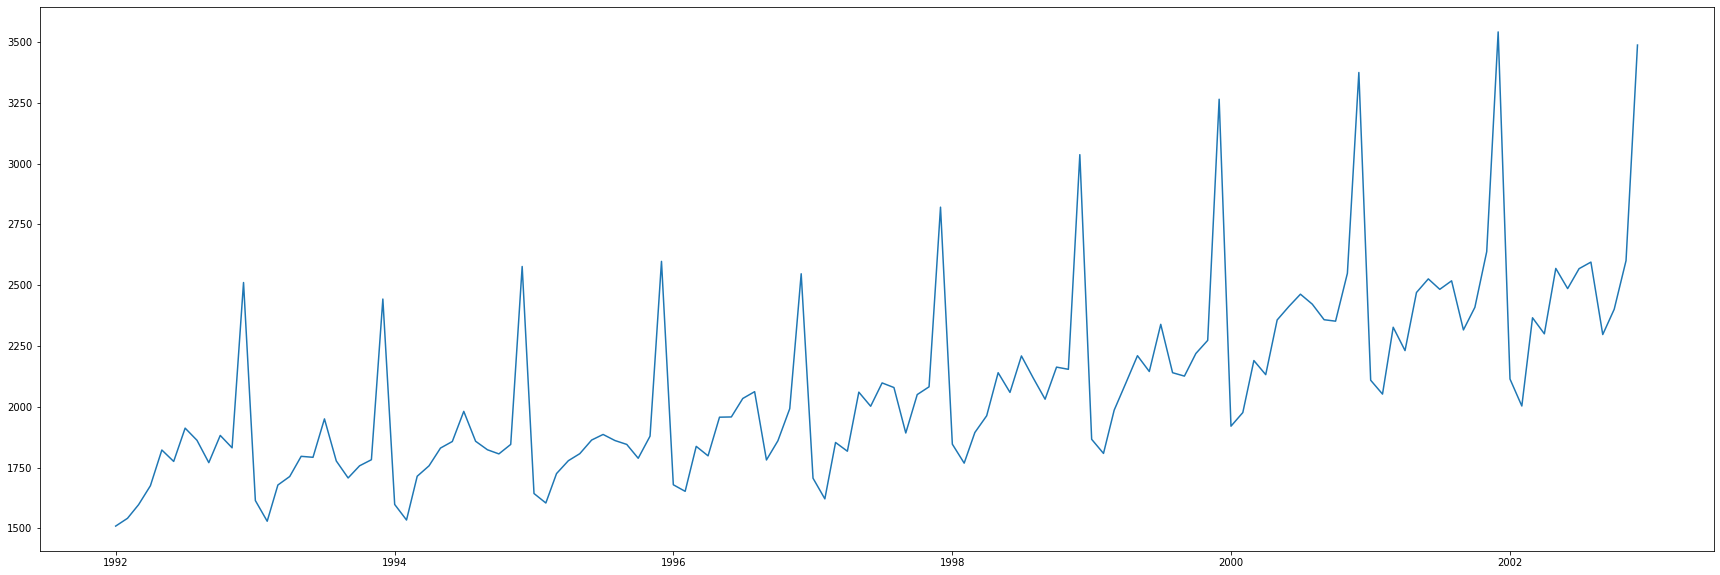

In [25]:
# Test cell for sales_period()
annual_period = sales_period(training_data)
assert type(annual_period)== bool


### Question 2.2 [5 points]
Complete the function `sales_decompose()` which should return the string "additive" (e.g. `return "additive"`) if the time series appears to be better fit by an additive model, or returns "multiplicative" if the time series appears to be better fit by a multiplicative model.  You should use visualization to determine the answer to this.

In [26]:
def sales_decompose(data):
    '''
    Uses visualization to determine if the data should be modeleted as an additive or multiplicative time series

    Inputs:
        data(DataFrame): dataframe with monthly sales data

    Returns:
        series_type(str): 'additive' or 'multiplicative' depending on which better fits the time series
    '''
    # YOUR CODE HERE
    add_model = sm.tsa.seasonal_decompose(data, model = 'additive')
    plt.rcParams['figure.figsize'] = [20,20]
    add_model.plot()
    plt.show()

    mult_model = sm.tsa.seasonal_decompose(data, model = 'multiplicative')
    plt.rcParams['figure.figsize'] = [20,20]
    mult_model.plot()
    plt.show()
    return 'multiplicative'

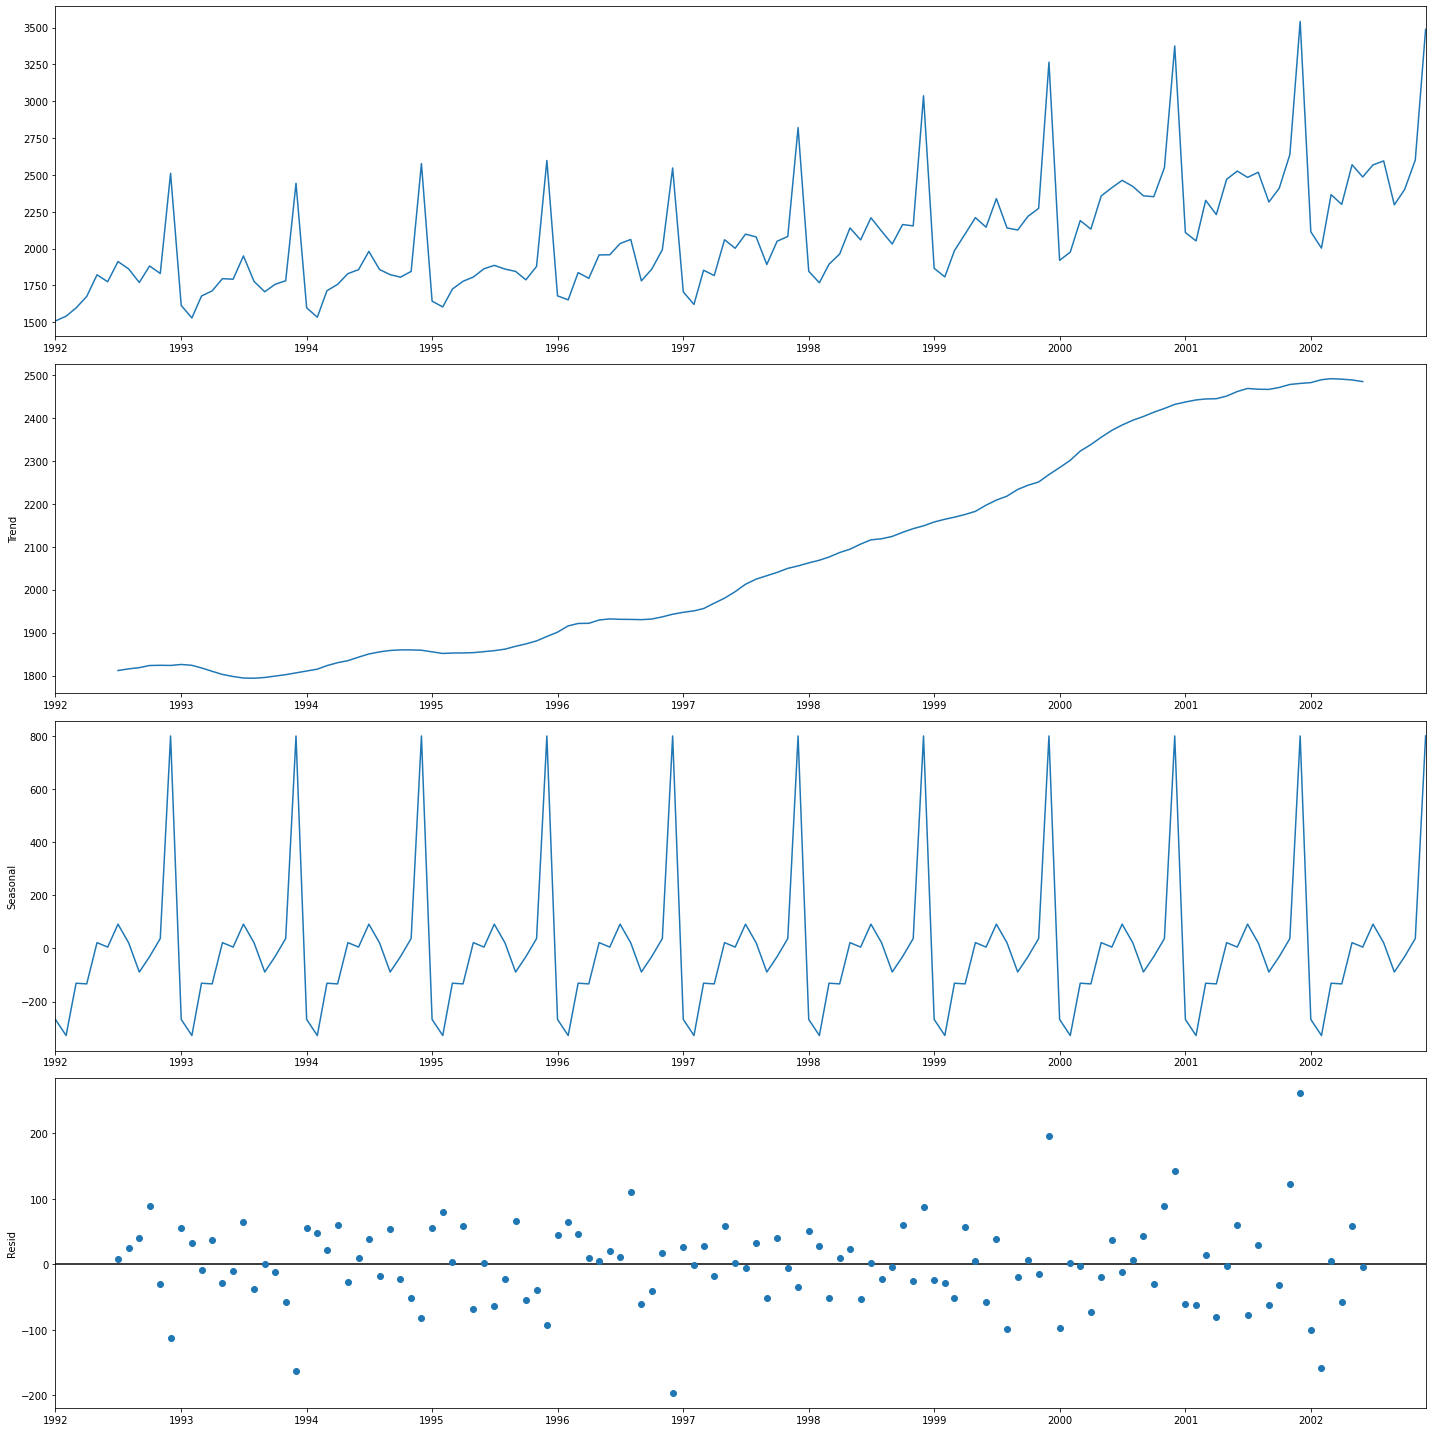

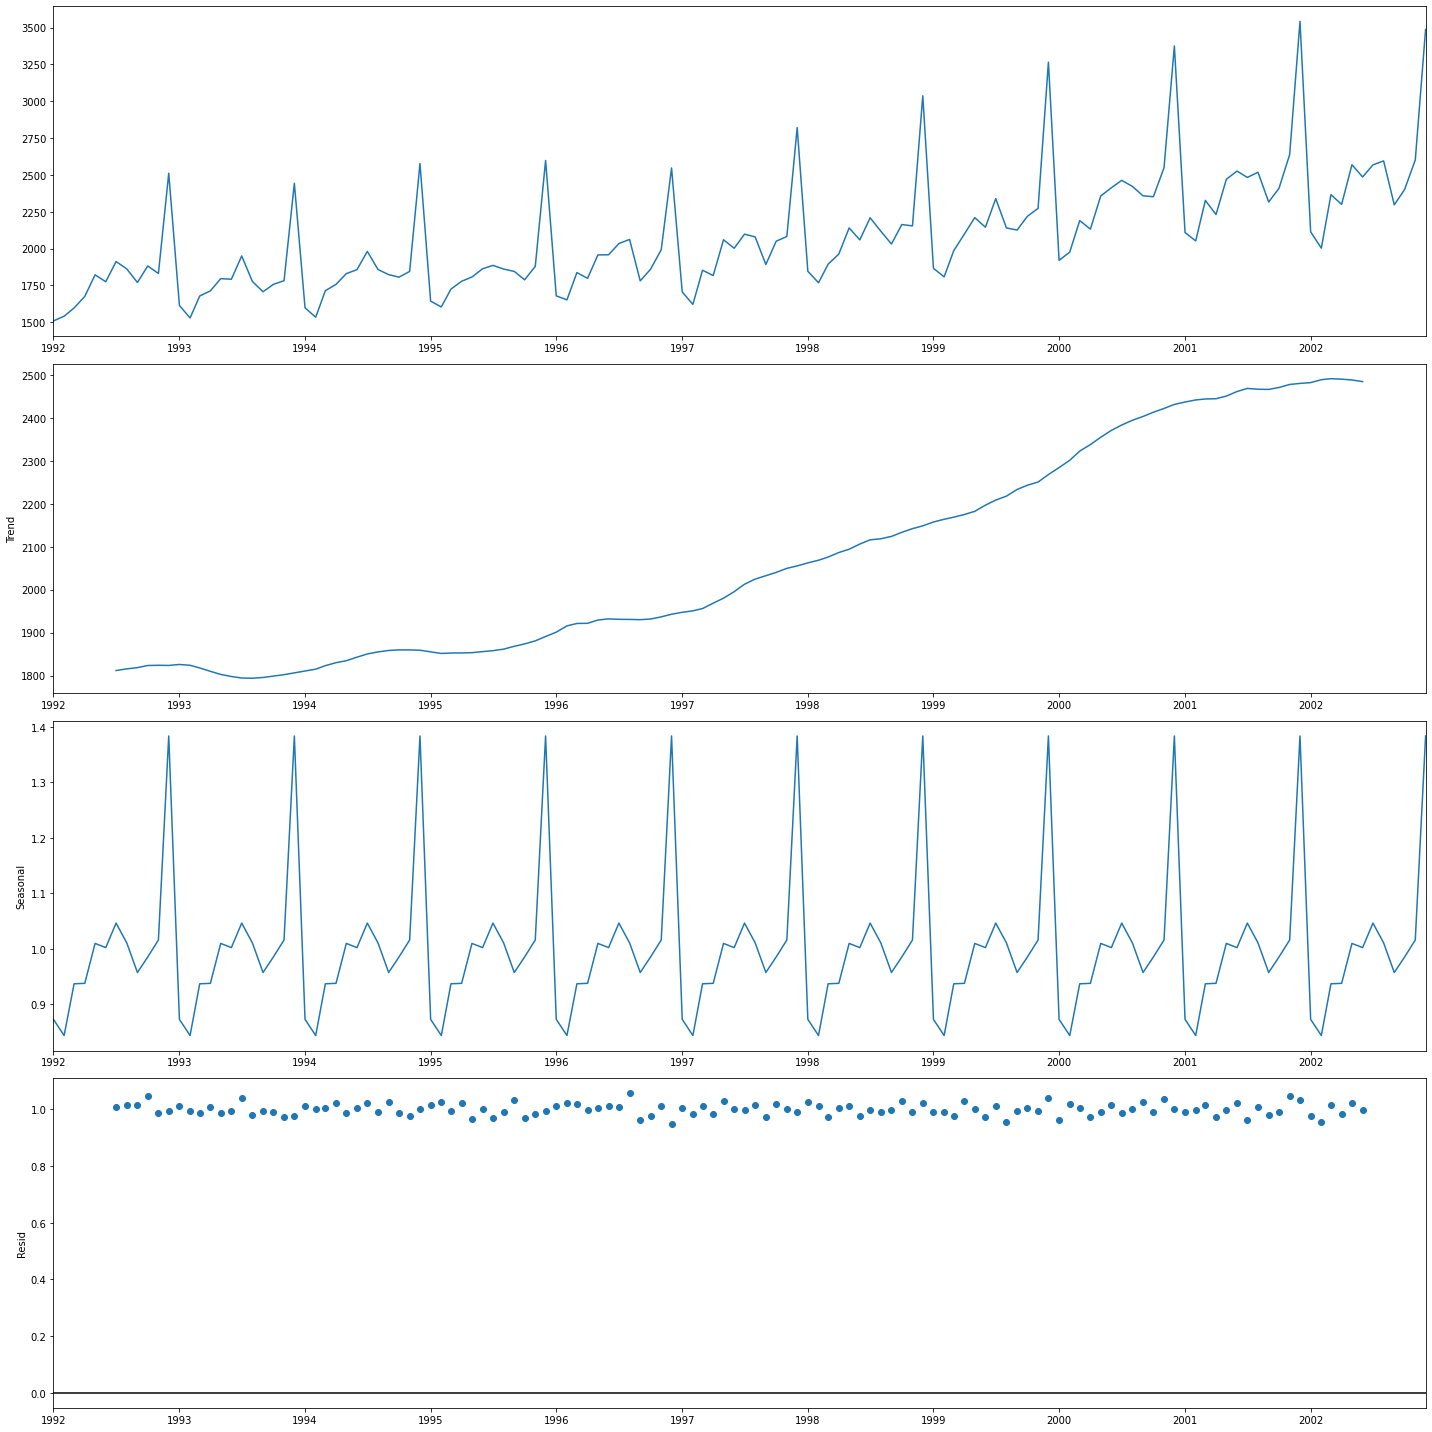

In [27]:
# Test cell for sales_decomposition()
ts_type = sales_decompose(training_data)
assert ts_type in ['additive','multiplicative']


### Question 2.3 [5 points]
Complete the below function `sales_autocorr()` which should return the lag value (in months, as an integer) with which sales has the highest autocorrelation (evaluate the autocorrelation up to a lag of 24 months).

In [28]:
from statsmodels.graphics.tsaplots import plot_acf

def sales_autocorr(data):
    '''
    Determins the lag value (in months) with which sales has the highest autocorrelation 

    Inputs:
        data(DataFrame): dataframe with monthly sales data

    Returns:
        best_lag(int): lag value in months with which sales has the highest autocorrelation (up to max of 24 months)
    '''
    # YOUR CODE HERE
    plot_acf(data)
    plt.show()

    acf = sm.tsa.acf(data)
    return acf[1:].argmax() + 1

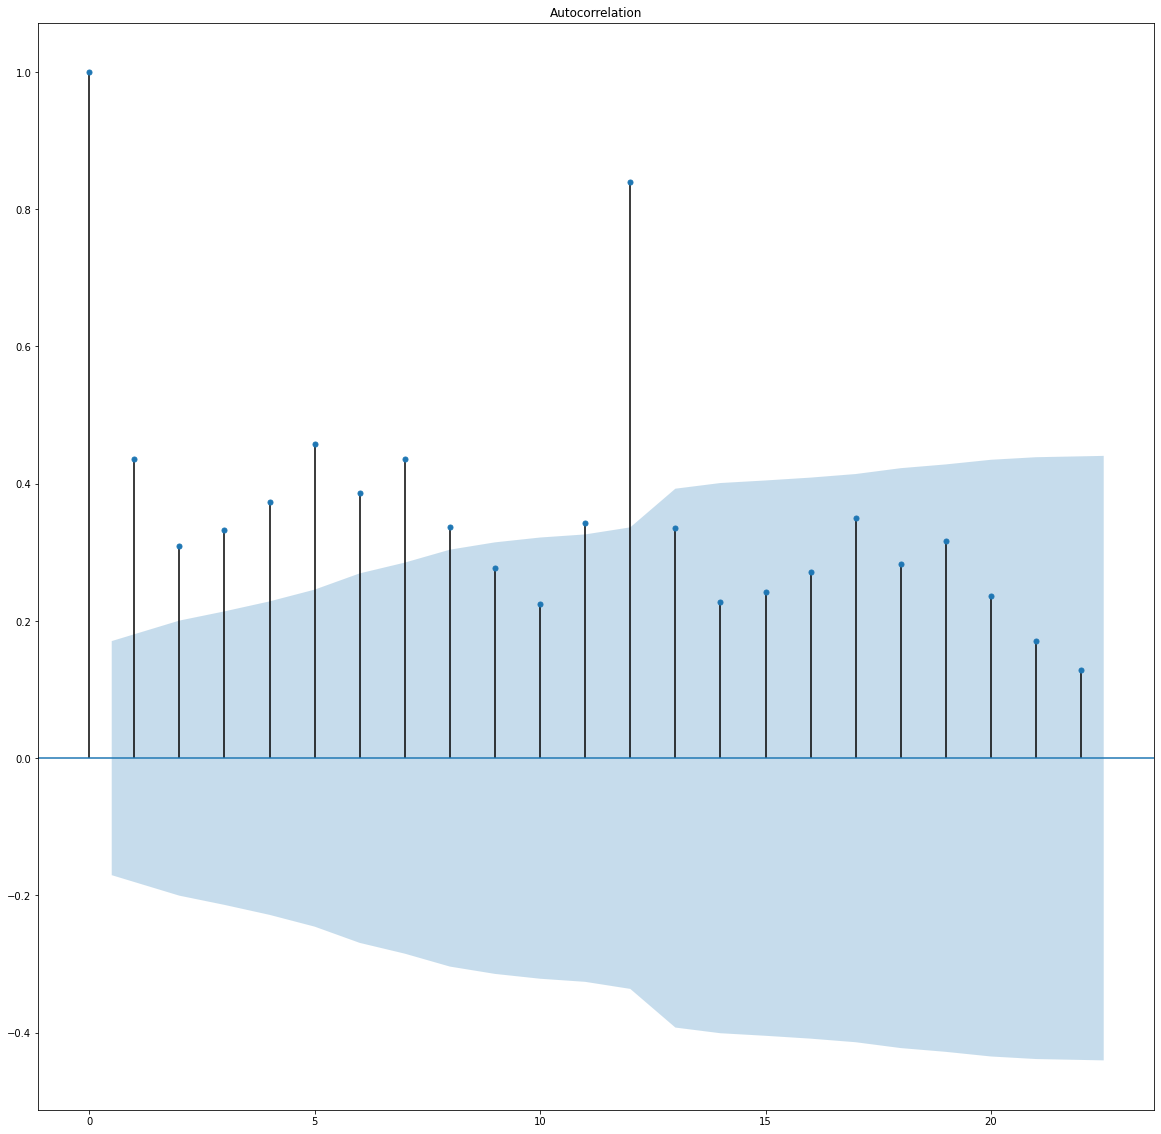

Your function found that sales has the highest autocorrelation at a lag of 12 months


In [29]:
# Test cell for sales_autocorr()
autocorr_month = sales_autocorr(training_data)
print('Your function found that sales has the highest autocorrelation at a lag of {} months'.format(autocorr_month))


### Question 2.4 [15 points]
Let's try to model sales using a linear regression to capture only the trend in the data.  Complete the below function `sales_trend_model()`.  The function should first create a new feature representing the number of months which have passed since the start of the training period.  You should then fit a linear regression model on the single feature representing the number of months passed.  After you have trained your model, use it to generate predictions on the training set and calculate the R-squared value of your training set predictions.  Your function should return your trained model object and the R-squared value as a float.

In [35]:
def sales_trend_model(data):
    '''
    Trains a linear regression model on the sales data using only the trend component by creating a feature representing number of months passed

    Inputs:
        data(DataFrame): dataframe with monthly sales data

    Returns:
        linmodel(sklearn.linear_model.LinearRegression()): linear regression model trained on the data
        r2(float): In-sample R-squared value of the model (calculated on the training data)
    '''
    # YOUR CODE HERE
    data['month'] = ((data.index - data.index.min()).days / 30).astype(int)
    model = LinearRegression()
    model.fit(X = data['month'].values.reshape(-1,1), y=data['Sales'])
    data['preds'] = model.predict(data['month'].values.reshape(-1,1))
    data['resids'] = data['Sales'] - data['preds']
    mse = np.sum(data['resids']**2,axis=0)/data.shape[0]
    r2 = 1-mse/np.var(data['Sales'])
    return model, r2

             Sales  month
DATE                     
1992-01-01  1509.0      0
1992-02-01  1541.0      1
1992-03-01  1597.0      2
1992-04-01  1675.0      3
1992-05-01  1822.0      4


(LinearRegression(), 0.4586614122119669)

In [36]:
# Test cell for sales_trend_model()
trend_model,rsquared = sales_trend_model(training_data.copy())
print('Your model has an R-squared of {:.3f} on the training data'.format(rsquared))
assert type(trend_model)==LinearRegression


             Sales  month
DATE                     
1992-01-01  1509.0      0
1992-02-01  1541.0      1
1992-03-01  1597.0      2
1992-04-01  1675.0      3
1992-05-01  1822.0      4
Your model has an R-squared of 0.459 on the training data


### Question 2.5 [5 points]
Complete the below function `create_test_set()` which takes the original full dataset (retail_data) as an input and returns a subset to use for the test set which consists of all the rows from the years 2003-2019, inclusive of 2003 and 2019.  Your test set should use the 'DATE' column as a datetime index and should have a single column "Sales" which includes the month sales.

In [41]:
def create_test_set(data):
    '''
    Creates a test set consisting of all sales data from years 2003 through 2019, inclusive

    Inputs:
        data(DataFrame): datafrom of the full monthly sales data

    Returns:
        test_set(DataFrame): dataframe containing the same columns as the input dataframe but filtered to only data from 2003 through 2019, inclusive
    '''
    # YOUR CODE HERE
    test_set = data.loc[(retail_data.index.year >= 2003) & (retail_data.index.year <= 2019)]
    return test_set

In [43]:
test_set = create_test_set(retail_data.copy())
display(test_set.head())
assert len(test_set)==204


204


,Sales
DATE,
2003-01-01,2121.0
2003-02-01,1940.0
2003-03-01,2187.0
2003-04-01,2333.0
2003-05-01,2576.0


### Question 2.6 [10 points]
Complete the below function `test_sales_trend_model()` which takes as input your trained linear regression model (which was returned from `sales_trend_model()`) and the test set (returned from `create_test_set`). The function should use the model to generate predictions on the test set, and then compute and return the R-squared value **of the test set predictions** as a float.  

Hint: in order to generate the test set input needed for your model, as you did above you will need to create a feature representing "months passed" for the test set.  However, be careful about the origin in calculating the "months passed" - to be consistent with the input your model expects, we need to calculate the number of "months passed" since the start of the training set (NOT since the start of the test set only). 

In [62]:
def test_sales_trend_model(model, training_data, test_data):
    '''
    Computes the R-squared value of the predictions from the trained autoregression model on the test set

    Inputs:
        model(sklearn.linear_model.LinearRegression()): linear regression model trained on the data
        training_data(pd.DataFrame): dataframe containing the training data
        test_data(pd.DataFrame): dataframe containing the test set data

    Returns:
        r2(float): R-squared value of the model on the test set data
    '''

    # YOUR CODE HERE
    start = training_data.index.min()
    test_data['time'] = ((test_data.index - start).days / 30).astype(int)
    test_data['preds'] = model.predict(test_data['time'].values.reshape(-1,1))
    test_data['resids'] = test_data['Sales'] - test_data['preds']
    mse = np.sum(test_data['resids']**2, axis=0)/test_data.shape[0]
    r2 = 1-mse/np.var(test_data.values)
    return r2

In [63]:
trend_r2_test = test_sales_trend_model(trend_model,training_data.copy(),test_set.copy())
print("Your model's R-squared on the test set was {:.3f}".format(trend_r2_test))


Your model's R-squared on the test set was 0.848


### Question 2.7 [15 points]
Now let's try to model this time series using the seasonality component alone, assuming that we have an annual seasonality and the sales varies by month of the year.  Complete the below function `sales_seasonality_model()` which takes the training dataset as input and creates a model which uses the "month_of_year" as the feature.  As we did in class, you should "one-hot encode" the "month_of_year" feature by creating 12 dummy columns each representing a month of the year. You should then train a linear regression model using ONLY these 12 columns/features representing each month.  After you have trained your model, generate the predictions on the training set and compute and return the R-squared value of the training set predictions, as a float.

In [70]:
def sales_seasonality_model(train_data):
    '''
    Models the sales using only an annual seasonal component and computes the R-squared on the training data

    Inputs:
        train_data(pd.DataFrame): dataframe containing the training data

    Returns:
        r2(float): In-sample R-squared value of the model on the training data
    '''
    # YOUR CODE HERE
    train_data['month'] = train_data.index.month
    df_encoded = pd.get_dummies(data = train_data, columns=['month'])
    model = LinearRegression()
    x = df_encoded.drop(labels='Sales', axis = 1)
    y = df_encoded['Sales']
    model.fit(x, y)
    df_encoded['preds'] = model.predict(x)
    df_encoded['resids'] = df_encoded['Sales'] - df_encoded['preds']
    mse = np.sum(df_encoded['resids']**2,axis=0)/df_encoded.shape[0]
    return 1 - mse/np.var(df_encoded['Sales'])


In [71]:
r2_seasonal = sales_seasonality_model(training_data.copy())
print("Your model's R-squared on the training set was {:.3f}".format(r2_seasonal))


Your model's R-squared on the training set was 0.539


### Question 2.8 [15 points]
Let's now create a model using both the trend component and the seasonality component.  Complete the below function `sales_trendandseasonality_model()` which takes the training set and test set as inputs.  Your function should first create the training set features needed for the model, including a feature 'months_passed' to capture the long term trend (as we did above in `sales_trend_model()` and 12 dummy columns/features each representing a month of the year to capture the seasonality component (as we did above in `sales_seasonality_model()`.  Your final training set should thus have 13 features.  Train a linear regression model on these features for the training data only.  Then, create the same features for your test set dates, and use your model to generate predictions on the test set dates.  Finally, calculate the R-squared value of the test set predictions and return it from the function as a float.

In [78]:
def sales_trendandseasonality_model(train_data,test_data):
    '''
    Models the sales data using both the trend and annual seasonality components, and calculates the R-squared on the test set

    Inputs:
        train_data(pd.DataFrame): dataframe containing the training data
        test_data(pd.DataFrame): dataframe containing the test set data

    Returns:
        r2_test(float): R-squared value of the model on the test set data
    '''

    # YOUR CODE HERE
    start = train_data.index.min()
    train_data['months_passed'] = ((train_data.index - start).days / 30).astype(int)
    train_data['month'] = train_data.index.month
    df_encoded = pd.get_dummies(data = train_data, columns=['month'])

    model = LinearRegression()
    x = df_encoded.drop(labels='Sales', axis = 1)
    y = df_encoded['Sales']
    model.fit(x, y)

    test_data['months_passed'] = ((test_data.index - start).days / 30).astype(int)
    test_data['month'] = test_data.index.month
    test_df_encoded = pd.get_dummies(data = test_data, columns=['month'])

    testx = test_df_encoded.drop(labels='Sales', axis = 1)
    test_df_encoded['preds'] = model.predict(testx)
    test_df_encoded['resids'] = test_df_encoded['Sales'] - test_df_encoded['preds']
    mse = np.sum(test_df_encoded['resids']**2,axis=0)/test_df_encoded.shape[0]
    return 1 - mse/np.var(test_df_encoded['Sales'])

In [79]:
r2score_test = sales_trendandseasonality_model(training_data.copy(),test_set.copy())
print("Your model's R-squared on the test set was {:.3f}".format(r2score_test))


Your model's R-squared on the test set was 0.531
